In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
import json
from os.path import expanduser
import pickle
import glob

### using AlphaTims to load the raw data

In [2]:
counts_l = []
counts_l.append({'minvi':600,'name':'minvi-600-2021-12-19-02-35-34','features_isol':86176,'peptides':10535,'sensitivity':12.2,'percent_all_features':55,'hours':15.4})
counts_l.append({'minvi':1000,'name':'minvi-1000-2021-12-17-22-14-22','features_isol':80791,'peptides':10487,'sensitivity':13,'percent_all_features':55,'hours':12.5})
counts_l.append({'minvi':2000,'name':'minvi-2000-2021-12-17-03-11-51','features_isol':67176,'peptides':10235,'sensitivity':15.2,'percent_all_features':54,'hours':8.4})
counts_l.append({'minvi':3000,'name':'minvi-3000-2021-12-19-16-28-05','features_isol':54239,'peptides':9858,'sensitivity':18,'percent_all_features':53,'hours':6})
counts_l.append({'minvi':4000,'name':'minvi-4000-2021-12-20-00-08-59','features_isol':43591,'peptides':9334,'sensitivity':21.4,'percent_all_features':51.2,'hours':4.6})
counts_l.append({'minvi':5000,'name':'minvi-5000-2021-12-20-19-01-47','features_isol':35498,'peptides':8677,'sensitivity':24.4,'percent_all_features':50.3,'hours':3.6})
counts_df = pd.DataFrame(counts_l)

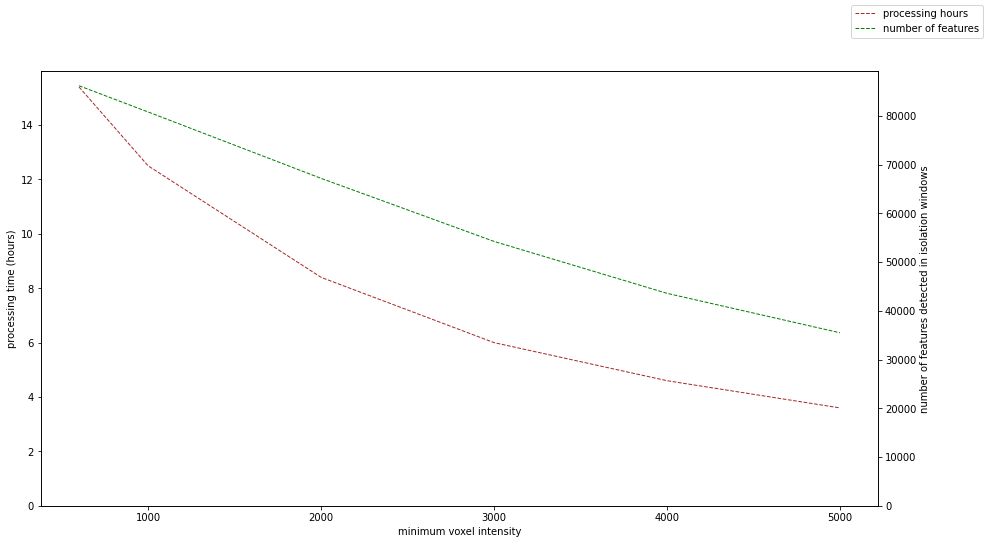

In [3]:
f, ax1 = plt.subplots()
ax2 = ax1.twinx()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the smoothed points
ax1.plot(counts_df.minvi, counts_df.hours, marker='', color='brown', linestyle='--', linewidth=1, ms=5, label='processing hours')
ax2.plot(counts_df.minvi, counts_df.features_isol, marker='', color='green', linestyle='--', linewidth=1, ms=5, label='number of features')

# plt.title('processing time and number of de-duped features by minimum voxel intensity')
f.legend()
ax1.set_xlabel("minimum voxel intensity")
ax1.set_ylabel("processing time (hours)")
ax1.set_ylim(0,)
ax2.set_ylabel("number of features detected in isolation windows")
ax2.set_ylim(0,)
plt.show()

### show % coverage of MaxQuant features by minvi value

In [4]:
experiment_name = 'P3856_YHE211'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

In [5]:
DUP_MZ_TOLERANCE_PPM = 10
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 5

In [6]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

##### load the MaxQuant idents from the file generated by the notebook "paper 4 - feature venn diagrams for MQ, PASEF, 3DID"

In [7]:
idents_mq_df = pd.read_feather('{}/identifications-mq/exp-P3856_YHE211-identifications-mq.feather'.format(EXPERIMENT_DIR))
idents_mq_df = idents_mq_df[idents_mq_df.isotope_count >= 3]

combined_idents_mq_df = idents_mq_df[combined_names].copy()
combined_idents_mq_df['method'] = 'mq'

In [8]:
idents_mq_df['percolator q-value'].max()

0.0098612126

In [9]:
minvi_values = [600,1000,2000,3000,4000,5000]

In [10]:
l = []
for minvi in minvi_values:
    # load the features detected by 3DID
    FEATURES_3DID_DIR = sorted(glob.glob('/media/big-ssd/results-P3856_YHE211-3did/minvi-{}-*/{}/features-3did'.format(minvi, experiment_name)))[-1]
    FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.feather'.format(FEATURES_3DID_DIR, experiment_name, run_name)
    print('processing {}'.format(FEATURES_3DID_FILE))
    features_3did_df = pd.read_feather(FEATURES_3DID_FILE)

    combined_idents_3did_df = features_3did_df[combined_names].copy()
    combined_idents_3did_df['method'] = '3did'

    combined_idents_df = pd.concat([combined_idents_mq_df,combined_idents_3did_df], axis=0, sort=False, ignore_index=True)
    combined_idents_df['method_feature_id'] = combined_idents_df.method+'-'+combined_idents_df.feature_id.astype('str')

    # set up dup definitions
    MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
    combined_idents_df['dup_mz'] = combined_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
    combined_idents_df['dup_mz_ppm_tolerance'] = combined_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
    combined_idents_df['dup_mz_lower'] = combined_idents_df.dup_mz - combined_idents_df.dup_mz_ppm_tolerance
    combined_idents_df['dup_mz_upper'] = combined_idents_df.dup_mz + combined_idents_df.dup_mz_ppm_tolerance
    combined_idents_df['dup_scan_lower'] = combined_idents_df.scan_apex - DUP_SCAN_TOLERANCE
    combined_idents_df['dup_scan_upper'] = combined_idents_df.scan_apex + DUP_SCAN_TOLERANCE
    combined_idents_df['dup_rt_lower'] = combined_idents_df.rt_apex - DUP_RT_TOLERANCE
    combined_idents_df['dup_rt_upper'] = combined_idents_df.rt_apex + DUP_RT_TOLERANCE

    combined_id = 1
    combined_features = []
    features_processed = set()
    for row in combined_idents_df.itertuples():
        if row.method_feature_id not in features_processed:
            df = combined_idents_df[(row.charge == combined_idents_df.charge) & (row.dup_mz >= combined_idents_df.dup_mz_lower) & (row.dup_mz <= combined_idents_df.dup_mz_upper) & (row.scan_apex >= combined_idents_df.dup_scan_lower) & (row.scan_apex <= combined_idents_df.dup_scan_upper) & (row.rt_apex >= combined_idents_df.dup_rt_lower) & (row.rt_apex <= combined_idents_df.dup_rt_upper)].copy()
            if len(df) > 0:
                # remove the features that have already been processed
                feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
                df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
                # record the features that have been processed
                features_processed.update(set(df.method_feature_id.tolist()))
                # separate the method feature ids
                feature_ids = {'3did':0, 'pasef':0, 'mq':0}
                for m in df.method_feature_id.tolist():
                    method = m.split('-')[0]
                    feature_id = int(m.split('-')[1])
                    feature_ids[method] = feature_id
                # store the features that were combined
                combined_features.append({'combined_id':combined_id, 'number_of_methods':len(df.method.unique()), 'methods':list(df.method.unique()), 'method_ids':df.method_feature_id.tolist(), '3did_feature_id':feature_ids['3did'], 'mq_feature_id':feature_ids['mq']})
                # update the combined feature identifier
                combined_id += 1
    combined_features_df = pd.DataFrame(combined_features)
    mq_total = len(combined_features_df[(combined_features_df.mq_feature_id > 0)])
    mq_covered_by_3did = len(combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)])
    mq_coverage_proportion = mq_covered_by_3did / mq_total
    l.append({'minvi':minvi,'mq_coverage_proportion':mq_coverage_proportion})

processing /media/big-ssd/results-P3856_YHE211-3did/minvi-600-2021-12-19-02-35-34/P3856_YHE211/features-3did/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather
processing /media/big-ssd/results-P3856_YHE211-3did/minvi-1000-2021-12-17-22-14-22/P3856_YHE211/features-3did/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather
processing /media/big-ssd/results-P3856_YHE211-3did/minvi-2000-2021-12-17-03-11-51/P3856_YHE211/features-3did/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather
processing /media/big-ssd/results-P3856_YHE211-3did/minvi-3000-2021-12-19-16-28-05/P3856_YHE211/features-3did/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather
processing /media/big-ssd/results-P3856_YHE211-3did/minvi-4000-2021-12-20-00-08-59/P3856_YHE211/features-3did/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather
processing /media/big-ssd/results-P3856_YHE211-3did/minv

In [11]:
mq_coverage_df = pd.DataFrame(l)

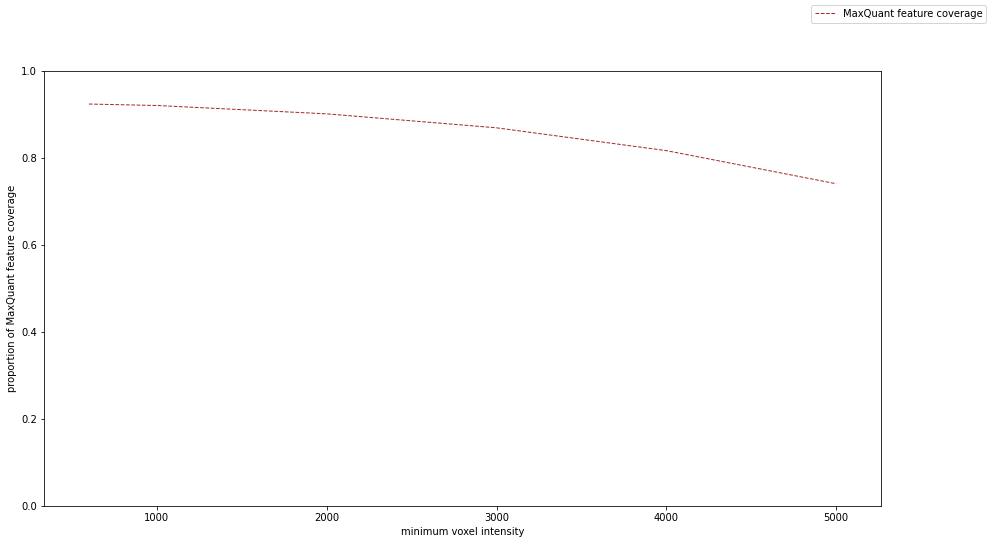

In [12]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

ax1.plot(mq_coverage_df.minvi, mq_coverage_df.mq_coverage_proportion, marker='', color='brown', linestyle='--', linewidth=1, ms=5, label='MaxQuant feature coverage')

# plt.title('processing time and number of de-duped features by minimum voxel intensity')
f.legend()
ax1.set_xlabel("minimum voxel intensity")
ax1.set_ylabel("proportion of MaxQuant feature coverage")
ax1.set_ylim(0,1)
plt.show()